In [1]:
from tqdm import tqdm
from IPython.utils import io
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Activation

In [2]:
wb = pd.read_excel('LSVT_voice_rehabilitation.xlsx', 'Data')
features = pd.DataFrame(wb)
wb = pd.read_excel('LSVT_voice_rehabilitation.xlsx', 'Binary response')
class_label = pd.DataFrame(wb)
class1 = [float(i==1) for i in class_label.iloc[:,0]]
class2 = [float(i==2) for i in class_label.iloc[:,0]]
class_label = class_label.to_numpy().flatten()

In [3]:
for col in features.columns:
    features[col] = (features[col] - features[col].mean())/features[col].abs().max()
    
features

,Jitter->F0_abs_dif,Jitter->F0_dif_percent,Jitter->F0_PQ5_classical_Schoentgen,Jitter->F0_PQ5_classical_Baken,Jitter->F0_PQ5_generalised_Schoentgen,Jitter->F0_abs0th_perturb,Jitter->F0_CV,Jitter->F0_TKEO_mean,Jitter->F0_TKEO_std,Jitter->F0_TKEO_prc5,...,det_TKEO_std4_1_coef,det_TKEO_std4_2_coef,det_TKEO_std4_3_coef,det_TKEO_std4_4_coef,det_TKEO_std4_5_coef,det_TKEO_std4_6_coef,det_TKEO_std4_7_coef,det_TKEO_std4_8_coef,det_TKEO_std4_9_coef,det_TKEO_std4_10_coef
0,-0.066468,-0.082890,-0.082838,-0.033340,-0.061249,-0.020482,-0.020964,-0.038804,-0.034952,0.051697,...,0.007903,0.007720,0.007247,0.008839,0.008847,0.008944,0.007002,0.007106,0.007410,0.008703
1,-0.030866,-0.066103,-0.064835,0.067838,-0.081925,-0.019871,-0.020953,0.012543,0.063958,0.025804,...,0.098795,0.099252,0.098005,0.098818,0.099766,0.098824,0.098327,0.098659,0.099034,0.099850
2,0.158872,0.561317,0.566592,-0.000542,0.519678,0.026310,0.066991,-0.032220,-0.108107,-0.009437,...,-0.200743,-0.199414,-0.200822,-0.203238,-0.203230,-0.207259,-0.209097,-0.208821,-0.208217,-0.209700
3,-0.094019,-0.098523,-0.098027,0.005216,-0.080907,-0.028275,-0.021021,-0.075258,-0.112129,0.061130,...,-0.144775,-0.144617,-0.145622,-0.145107,-0.145004,-0.145269,-0.146545,-0.146343,-0.146087,-0.144950
4,-0.072234,-0.085704,-0.099164,0.308458,0.003853,-0.025916,-0.014811,-0.028485,-0.015284,0.057475,...,-0.013641,-0.011525,-0.016298,-0.013042,-0.013413,-0.013737,-0.015313,-0.015339,-0.014901,-0.014022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,-0.052890,-0.051978,-0.050158,0.038097,-0.069764,-0.023081,-0.020920,-0.053079,-0.073146,0.046347,...,-0.051373,-0.050153,-0.049881,-0.048588,-0.048659,-0.049199,-0.048967,-0.049027,-0.048948,-0.048341
122,0.229291,0.230740,0.235550,0.099006,0.043501,-0.010882,-0.019039,0.024780,-0.017329,-0.092600,...,0.013112,0.015052,0.019401,0.020243,0.019213,0.018342,0.018686,0.017352,0.018778,0.018789
123,-0.073946,-0.073197,-0.072134,-0.050451,-0.060094,0.000215,-0.020981,-0.066567,-0.095212,0.056477,...,-0.089750,-0.089863,-0.091204,-0.091731,-0.091193,-0.091616,-0.092902,-0.092842,-0.092632,-0.090879
124,-0.055234,-0.069454,-0.067720,-0.009375,-0.075070,-0.022874,-0.020989,-0.037867,-0.034837,0.048065,...,0.011250,0.011519,0.010806,0.011183,0.011701,0.011451,0.011090,0.010679,0.010554,0.011329


In [4]:
classes = {'Acceptable': class1, 'Unacceptable': class2}
classes = pd.DataFrame(classes)
classes

,Acceptable,Unacceptable
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0
...,...,...
121,0.0,1.0
122,0.0,1.0
123,1.0,0.0
124,0.0,1.0


In [5]:
model = Sequential([
    
    InputLayer(input_shape=(features.shape[1])),
    
    Dense(7, activation='sigmoid'),
    
    Dense(5, activation='sigmoid'),
    
    Dense(2, activation='relu')
])

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

model.summary()

model.save_weights('model_weights/initial_weights_voice')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 2177      
                                                                 
 dense_1 (Dense)             (None, 5)                 40        
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 2,229
Trainable params: 2,229
Non-trainable params: 0
_________________________________________________________________


In [6]:
acc = 0
j = 0
for train_index, test_index in KFold(10).split(features):
    x_train, x_test = features.iloc[train_index,:], features.iloc[test_index,:]
    y_train, y_test = classes.iloc[train_index,:], classes.iloc[test_index,:]
    model.load_weights('model_weights/initial_weights_voice')
    with io.capture_output() as captured:
        model.fit(x_train, y_train, epochs=1000)
    acc += model.evaluate(x_test, y_test)[1]
    j+=1

1/1 [==============================] - 0s 18ms/step - loss: 3.4129 - accuracy: 0.8333


In [7]:
acc/j

0.8346153914928436

In [8]:
model.fit(features, classes, epochs=500)

Epoch 1/500
4/4 [==============================] - 0s 3ms/step - loss: 2.6511 - accuracy: 0.9841
Epoch 2/500
4/4 [==============================] - 0s 3ms/step - loss: 2.6495 - accuracy: 0.9603
Epoch 3/500
4/4 [==============================] - 0s 3ms/step - loss: 2.6474 - accuracy: 0.9603
Epoch 4/500
4/4 [==============================] - 0s 3ms/step - loss: 2.6047 - accuracy: 0.9524
Epoch 5/500
4/4 [==============================] - 0s 3ms/step - loss: 2.5932 - accuracy: 0.9127
Epoch 6/500
4/4 [==============================] - 0s 3ms/step - loss: 2.5911 - accuracy: 0.8810
Epoch 7/500
4/4 [==============================] - 0s 3ms/step - loss: 2.5886 - accuracy: 0.8810
Epoch 8/500
4/4 [==============================] - 0s 3ms/step - loss: 2.5878 - accuracy: 0.8889
Epoch 9/500
4/4 [==============================] - 0s 3ms/step - loss: 2.5873 - accuracy: 0.8968
Epoch 10/500
4/4 [==============================] - 0s 3ms/step - loss: 2.5864 - accuracy: 0.9048
Epoch 11/500
4/4 [===========

In [9]:
grad_sum = 0
for col_name in tqdm(features.columns):
    pointFrame = features.loc[:, features.columns != col_name]
    for i in features[col_name]:
        pointFrame[col_name] = i*np.ones(len(features.index))
        points = tf.Variable(pointFrame, dtype='float')
        with tf.GradientTape() as tape:
            pred = model(points, training=False)
        grads = tape.gradient(pred, points)
        grad_sum += np.abs(grads.numpy())
saliency_order = np.argsort(np.sum(np.abs(grad_sum),0))

100%|██████████| 310/310 [01:55<00:00,  2.68it/s]


[]

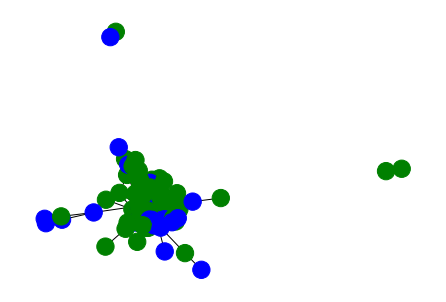

In [10]:
num_features = 35

salient_features = features.iloc[:,saliency_order[0:num_features]]
A = np.zeros((features.shape[0], features.shape[0]))
for i in features.index:
    for j in range(i):
        A[i,j] = np.linalg.norm(salient_features.iloc[i,:] - salient_features.iloc[j,:])
A = A + np.transpose(A)
# print(A)
# p = np.median(A).astype('int')
p = 0.5
A = (A <= p)
A = A - np.eye(A.shape[0])
rows, cols = np.where(A==1)
edges = zip(rows.tolist(), cols.tolist())
G = nx.Graph()
G.add_edges_from(edges, node_size=1)
color_map = np.array([])
acceptable = np.array([])
unacceptable = np.array([])
for node in G:
    if (class_label[node]==1):
        acceptable = np.append(acceptable, node)
        color_map = np.append(color_map, 'blue')
    else:
        unacceptable = np.append(unacceptable, node)
        color_map = np.append(color_map, 'green')
nx.draw(G, node_color=color_map)
plt.plot()

[]

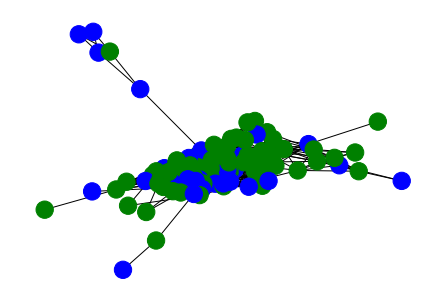

In [11]:
giant_component = G.subgraph(max(nx.connected_components(G), key=len))
color_map_GC = np.array([])
for node in giant_component:
    if (class_label[node]==1):
        color_map_GC = np.append(color_map_GC, 'blue')
    else:
        color_map_GC = np.append(color_map_GC, 'green')
nx.draw(giant_component, node_color=color_map_GC)
plt.plot()

[]

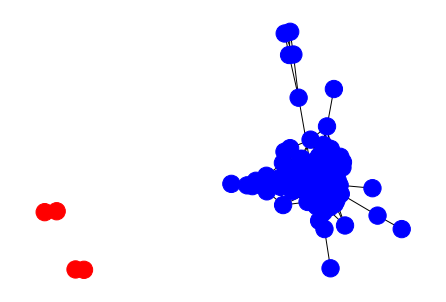

In [12]:
giant_component = G.subgraph(max(nx.connected_components(G), key=len))
color_map_GC = np.array([])
for node in G:
    if node in giant_component:
        color_map_GC = np.append(color_map_GC, 'blue')
    else:
        color_map_GC = np.append(color_map_GC, 'red')
nx.draw(G, node_color=color_map_GC)
plt.plot()

In [13]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(salient_features)
print('***KMEANS***')
print('Inertia: ', kmeans.inertia_)
print('Cluster Centers: ', kmeans.cluster_centers_)
print('Number of Iterations: ', kmeans.n_iter_)
predicted_label = kmeans.labels_

***KMEANS***
Inertia:  63.58312874062011
Cluster Centers:  [[ 0.00185915  0.01468322 -0.04484177  0.00543986 -0.00796914 -0.00605356
  -0.04415591 -0.0030345   0.00186763  0.07689464  0.07472549 -0.0076843
  -0.00679782 -0.00753674  0.07506938  0.07664336  0.01524688 -0.00663752
  -0.00473842 -0.00637496 -0.00569614  0.00354547  0.00111912  0.07454526
  -0.00331346 -0.04304238  0.07577478  0.00404827 -0.04509344  0.00786175
   0.00293989 -0.04339441 -0.04266036 -0.04453956 -0.00644474]
 [-0.00621855 -0.04911285  0.14998798 -0.0181954   0.02665538  0.0202481
   0.1476939   0.01014988 -0.00624691 -0.25719931 -0.2499439   0.02570265
   0.02273755  0.02520909 -0.25109414 -0.25635884 -0.05099817  0.02220136
   0.0158492   0.02132315  0.0190526  -0.01185897 -0.00374327 -0.24934103
   0.01108295  0.14396934 -0.25345356 -0.01354077  0.15082979 -0.0262962
  -0.00983343  0.1451468   0.14269154  0.14897716  0.02155654]]
Number of Iterations:  11


In [14]:
predicted_label

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [15]:
compared_classes = class_label - 1
print('KMeans accuracy: ', np.count_nonzero(compared_classes!=predicted_label)/len(predicted_label))

KMeans accuracy:  0.5


In [16]:
print(f'Eccentricity of giant component: {nx.eccentricity(giant_component)}') # largest possible shortest path distance between a vertex and all other vertices
print(f'Diameter of giant component: {nx.diameter(giant_component)}') # maximum shortest distance between a pair of vertices in G, it is the largest possible eccentricity value of a vertex
print(f'Radius of giant component: {nx.radius(giant_component)}') #  minimum eccentricity value of a vertex

print(f'Degree centrality: \n{nx.degree_centrality(G)}') # number of edges incident upon a vertex
print(f'Maximum degree centrality: {max(nx.degree_centrality(G))}')
print(f'Degree histogram: {nx.degree_histogram(G)}') # making a histogram of the distribution of degrees

# below gives us the different centrality measures for the vertices of the graphs
print(f'Eigenvector centrality: \n{nx.eigenvector_centrality(G)}')
print(f'Maximum eigenvector centrality: {max(nx.eigenvector_centrality(G))}')
print(f'Closeness centrality: \n{nx.closeness_centrality(G)}')
print(f'Maximum closeness centrality: {max(nx.closeness_centrality(G))}')
print(f'Betweeness centrality: \n{nx.betweenness_centrality(G)}')
print(f'Maximum betweeness centrality: {max(nx.betweenness_centrality(G))}')

Eccentricity of giant component: {0: 4, 1: 5, 4: 5, 5: 4, 9: 4, 15: 5, 18: 4, 24: 4, 28: 4, 29: 5, 33: 5, 35: 4, 36: 4, 39: 4, 45: 4, 46: 4, 48: 4, 55: 5, 57: 4, 69: 4, 72: 5, 73: 5, 74: 5, 84: 4, 85: 4, 88: 4, 94: 5, 100: 4, 101: 5, 103: 4, 108: 4, 112: 5, 113: 5, 118: 4, 119: 4, 121: 5, 122: 4, 124: 4, 16: 5, 20: 5, 34: 4, 49: 5, 54: 5, 82: 5, 83: 5, 3: 6, 114: 5, 75: 6, 6: 5, 8: 5, 17: 4, 19: 5, 21: 5, 23: 5, 27: 5, 30: 5, 31: 5, 32: 4, 38: 4, 40: 4, 42: 5, 60: 4, 76: 5, 89: 5, 91: 5, 92: 5, 97: 4, 102: 5, 109: 5, 110: 4, 115: 5, 116: 5, 117: 5, 123: 5, 70: 5, 71: 5, 87: 5, 99: 5, 120: 5, 41: 6, 52: 6, 95: 5, 22: 5, 10: 7, 11: 6, 50: 6, 51: 6, 65: 6, 66: 7, 80: 6, 13: 5, 37: 5, 47: 5, 61: 5, 12: 5, 125: 6, 26: 6, 25: 6, 56: 5, 64: 5, 90: 5, 111: 5, 81: 5, 77: 7, 67: 7, 79: 6, 78: 6, 93: 7, 105: 7, 106: 6, 96: 7}
Diameter of giant component: 7
Radius of giant component: 4
Degree centrality: 
{0: 0.32456140350877194, 1: 0.14912280701754385, 4: 0.15789473684210525, 5: 0.447368421052631

In [17]:
print(f"The clustering value of each vertex{nx.clustering(G)}")
print(nx.average_clustering(G)) # 
print(nx.transitivity(G))# 3* number of triangles in G/ number of connected triads in G
print(nx.is_connected(G))
print(nx.number_connected_components(G)) # number of different connected components

The clustering value of each vertex{0: 0.6336336336336337, 1: 0.5808823529411765, 4: 0.7581699346405228, 5: 0.5803921568627451, 9: 0.6405919661733616, 15: 0.6597560975609756, 18: 0.5527603074772887, 24: 0.6448202959830867, 28: 0.6586059743954481, 29: 0.6442687747035574, 33: 0.6892307692307692, 35: 0.7076612903225806, 36: 0.5828282828282828, 39: 0.5818815331010453, 45: 0.6125603864734299, 46: 0.5868945868945868, 48: 0.6234817813765182, 55: 0.6358974358974359, 57: 0.6381461675579323, 69: 0.6474358974358975, 72: 0.6205128205128205, 73: 0.8021978021978022, 74: 0.5751633986928104, 84: 0.5566037735849056, 85: 0.6516516516516516, 88: 0.5450733752620545, 94: 0.6524216524216524, 100: 0.5990338164251208, 101: 0.7904761904761904, 103: 0.6356589147286822, 108: 0.5848484848484848, 112: 0.6746031746031746, 113: 0.7083333333333334, 118: 0.5779591836734694, 119: 0.7522522522522522, 121: 0.6956521739130435, 122: 0.8853754940711462, 124: 0.603145235892692, 16: 1.0, 20: 0.5555555555555556, 34: 0.61640211

In [18]:
giant_component = G.subgraph(max(nx.connected_components(G), key=len))

print(f"Density: {nx.density(giant_component)}")
print(f"Diameter: {nx.diameter(giant_component)}")
print(f"Radius: {nx.radius(giant_component)}")
print(f"Number Of Isolates: {nx.number_of_isolates(giant_component)}")
print(f"Average clustering value: {nx.average_clustering(giant_component)}")
print(f"Transitivity value: {nx.transitivity(giant_component)}")
print(f"Whether graph is connected: {nx.is_connected(giant_component)}")
print(f"Number of Connected Components: {nx.number_connected_components(giant_component)}")


Density: 0.21998361998361998
Diameter: 7
Radius: 4
Number Of Isolates: 0
Average clustering value: 0.6600660699249681
Transitivity value: 0.6402063992997167
Whether graph is connected: True
Number of Connected Components: 1
